# Setup

In [1]:
dpi=150
lw=2
size_fac=5.25
fftkde_res=2**22 # less than default


In [2]:
import h5py # h5py
import numpy as np # numpy
import os # os
from multiprocessing import cpu_count, Pool # multiprocessing
import gc # garbage collection
import pandas as pd # pandas
from PIL import ImageColor # pillow
import cv2 # opencv
from tqdm import tqdm
from numba import jit, prange
import random
from numba_progress import ProgressBar

 # scipy
from scipy import stats
from scipy.integrate import simpson
from scipy import linalg as la

# astropy
from astropy.visualization import hist
import astropy.constants as c
import astropy.units as u

# uncertainties
from uncertainties import ufloat
from uncertainties.umath import *
import uncertainties.unumpy as unp

# matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
from matplotlib import rcParams
rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.dpi'] = dpi
plt.rcParams['savefig.dpi'] = dpi
rc('text', usetex=True)
rc('font', size=12)
rc('legend', fontsize=12)
plt.rcParams['text.latex.preamble'] = r"""\usepackage{bm} \usepackage{amsmath} \usepackage{cmbright}
    \usepackage{siunitx} \usepackage{lmodern} \usepackage{sfmath} \sffamily \boldmath"""
from matplotlib import rcParams
import matplotlib.font_manager as font_manager
fontleg = font_manager.FontProperties(weight='bold') # bold legends
mpl.rcParams['xtick.major.pad'] = 14 * 1.5
mpl.rcParams['ytick.major.pad'] = 14 * 1.5

# orbitize, + my plotting code
import orbitize
from orbitize import read_input, priors, driver, system, sampler, results

# my functions!
from modified_plot import *
from fftkde_cred_int import *
from parallel_plots import generate_corner_plots

# KDEpy
from KDEpy import FFTKDE
from KDEpy.bw_selection import silvermans_rule, improved_sheather_jones

# Constants
PI = np.pi


In [3]:
my_colors = ["#0d0887","#2c0594","#43039e","#5901a5","#6e00a8","#8305a7","#9511a1","#a72197",
          "#b6308b","#c5407e","#d14e72","#dd5e66","#e76e5b","#f07f4f","#f79044","#fca338",
          "#feb72d","#fccd25"]

# Configure matplotlib once
configure_matplotlib(dpi, size_fac)


In [4]:
def redistribute_rgb(r, g, b):
    threshold = 255.999
    m = max(r, g, b)
    if m <= threshold:
        return int(r), int(g), int(b)
    total = r + g + b
    if total >= 3 * threshold:
        return int(threshold), int(threshold), int(threshold)
    x = (3 * threshold - total) / (3 * m - total)
    gray = threshold - x * m
    return int(gray + x * r), int(gray + x * g), int(gray + x * b)

my_colors_rgb = np.array([mpl.colors.to_rgb(my_colors[i]) for i in range(len(my_colors))])

 # multiply to brighten
my_lighter_colors = np.array([my_colors_rgb[i] * 255 * np.logspace(np.log10(2.2), np.log10(1.0), len(my_colors))[i] for i in range(len(my_colors))])

# redistribute with function above to maintain hue
my_lighter_colors = np.array([redistribute_rgb(*my_lighter_colors[i])
                               for i in range(len(my_colors))])
my_lighter_colors = my_lighter_colors / 255


Now we have imported orbitize, and entered the name of our CSV data file containing relative astrometry for all of the relevant epochs

## System mass (by component and total)

In [5]:
# both in solar masses
m_A = ufloat(1.22, 0.09)
m_B = ufloat(63, 3) * u.Mjup.to(u.Msun)

m_tot_prime = m_A + m_B
print(f"""Total mass of hii1348 with both uncertainties: {m_tot_prime} M_Sol""")
print()
print(f"""M_B = {m_B} M_Sol""")

m_tot_err = np.sqrt(m_A.s**2 + m_B.s**2)
print()
print(f"""Error on total mass of hii1348: {m_tot_err} M_sol""")

m_tot = m_A.n + m_B.n
print()
print(f"""Nominal total mass of hii1348: {m_tot} M_sol""")


Total mass of hii1348 with both uncertainties: 1.28+/-0.09 M_Sol

M_B = 0.0601+/-0.0029 M_Sol

Error on total mass of hii1348: 0.09004555098039961 M_sol

Nominal total mass of hii1348: 1.2801394367400674 M_sol


In [6]:
path_to_file = 'hii1348b_orbitize_data.csv'
data = read_input.read_file(path_to_file)

Old run from September

In [7]:
# From Blunt+ 2023 paper on HIP 65426 b
# Also, "emcee" settings: cite this?
"""
These are the MCMC parameters I'd use if I were publishing this fit.
This would take a while to run (takes about a day on my machine).
""" # (https://orbitize.readthedocs.io/en/latest/tutorials/Hipparcos_IAD.html#Part-3:-Using-the-IAD-in-your-Orbit-fit)
num_temps = 20
num_walkers = 1_000
num_orbits = 30_000_000
n_steps = num_orbits / num_walkers

burn_steps = 30_000
thin = 3
# num_threads = mp.cpu_count()
num_secondary_bodies = 1

plx = 6.979
plx_err = 0.0305

myDriver = driver.Driver(
    path_to_file.format(orbitize.DATADIR),
    'MCMC',            # 'OFTI' or 'MCMC'
    num_secondary_bodies, # number of planets in the system (here, a star)
    m_tot_prime.n,     # Procyon A nominal mass
    plx,             # System parallax in mas from SIMBAD
    mass_err=m_tot_prime.s,    # Mass error
    plx_err=plx_err,     # Parallax error in mas from SIMBAD
    system_kwargs={
        "restrict_angle_ranges": True
    },
    mcmc_kwargs={
         "num_temps": num_temps,
         "num_walkers": num_walkers,
         # "num_threads": num_threads
    }
)

# system, parameter labels
sys = myDriver.system
lab = sys.param_idx

s = myDriver.sampler


## Read-in Results

In [8]:
save_file = 'hii_1348b_30M_orbits_MCMC_OFTI_walker_pos_30_000_burn_in.hdf5'# 'orbits_OFTI_final.hdf5'
sampler='MCMC_30M_final'

hf = h5py.File(save_file, "r")  # Opens file for reading
# Load up each dataset from hdf5 file
sampler_name = str(hf.attrs["sampler_name"])
post = np.array(hf.get("post"))
lnlike = np.array(hf.get("lnlike"))
hf.close()  # Don't forget to close the file

orbits = np.array(random.sample(list(post), 1_000_000))# reduce by 100x for easier calc.

# fractional height of value annotations
annotation_y_frac = 0.75

# orbits now has the orbital elements of each orbit
sma = orbits[:,0] # semi-major axis
ecc = orbits[:,1] # eccentricity
inc = orbits[:,2] * (180/PI) # inclination
omega = orbits[:,3] * (180/PI) # position angle of nodes
pan = orbits[:,4] * (180/PI) # position angle of nodes in rad
tau = orbits[:,5] # epoch of periastron passage
plx = orbits[:,6]
mtot = orbits[:,7]

# put these all into an array
adjusted_units_orbits = np.array([sma, ecc, inc, omega, pan, tau, plx, mtot])

# orbital period
period = np.sqrt(
    4 * np.pi**2.0 * (sma * u.AU)** 3 / (c.G * (mtot * u.Msun))
)
period = period.to(u.year).value


# Reported Values

## Mean and STDEV Values:

In [9]:
print('Mean +- STDEV Parameters fit by MCMC:')
print('----------------------------------------\n')
means_and_stds = []
for i,element_name in enumerate(lab.keys()):
    
    element = adjusted_units_orbits[i]
    element_mean = np.mean(element)
    element_std = np.std(element, ddof=1)
    
    print(f'{element_name} = {element_mean:.5f} +- {element_std:.5f}')
    means_and_stds.append(ufloat(element_mean, element_std))
    
means_and_stds = np.array(means_and_stds)


print('\n\nComputed parameters from some of the above fitted parameters:')
print('-------------------------------------------------------------\n')

# orbital period from Kepler's third law (not a fitted parameter directly)
period_mean = np.mean(period)
period_std = np.std(period, ddof=1)
print(f'period = {period_mean:.5f} +- {period_std:.5f}')# years



Mean +- STDEV Parameters fit by MCMC:
----------------------------------------

sma1 = 316.75270 +- 426.24558
ecc1 = 0.61032 +- 0.21974
inc1 = 129.69887 +- 17.54177
aop1 = 152.22447 +- 132.09088
pan1 = 125.66291 +- 40.82198
tau1 = 0.82990 +- 0.17278
plx = 6.97915 +- 0.03061
mtot = 1.28714 +- 0.08968


Computed parameters from some of the above fitted parameters:
-------------------------------------------------------------

period = 7079.18301 +- 24809.00837


## Med and MAD:

In [10]:
print('Median +- MAD Parameters fit by MCMC:')
print('----------------------------------------\n')
meds_and_mads = []
for i,element_name in enumerate(lab.keys()):
    
    element = adjusted_units_orbits[i]
    element_med = np.median(element)
    element_mad = stats.median_abs_deviation(element)
    
    print(f'{element_name} = {element_med:.5f} +- {element_mad:.5f}')
    meds_and_mads.append(ufloat(element_med, element_mad))
    
meds_and_mads = np.array(meds_and_mads)


print('\n\nComputed parameters from some of the above fitted parameters:')
print('-------------------------------------------------------------\n')

# orbital period from Kepler's third law (not a fitted parameter directly)
period_med = np.median(period)
period_mad = stats.median_abs_deviation(period)
print(f'period = {period_med:.5f} +- {period_mad:.5f}')# years


Median +- MAD Parameters fit by MCMC:
----------------------------------------

sma1 = 205.36358 +- 59.59500
ecc1 = 0.65636 +- 0.15121
inc1 = 126.56662 +- 12.64358
aop1 = 90.63126 +- 73.55633
pan1 = 137.59736 +- 15.15213
tau1 = 0.85648 +- 0.06043
plx = 6.97917 +- 0.02096
mtot = 1.28806 +- 0.06043


Computed parameters from some of the above fitted parameters:
-------------------------------------------------------------

period = 2597.52183 +- 1080.14525


## Most Likely Orbit Values (not posterior):

In [11]:
max_log_like_post_i = np.where(lnlike == np.amax(lnlike))[0][0]
best_post = post[max_log_like_post_i].copy()
print(best_post)

best_post[2] *= 180 / np.pi # rad to deg inc
best_post[3] *= 180 / np.pi # rad to deg aop
best_post[4] *= 180 / np.pi # rad to deg pan

[4.53965297e+02 7.16835510e-01 2.01351306e+00 7.70129585e-02
 2.11207291e+00 9.32718889e-01 6.99996331e+00 1.39132620e+00]


In [12]:
best_sma = best_post[0] # semi-major axis
best_ecc = best_post[1] # eccentricity
best_inc = best_post[2] # inclination
best_omega = best_post[3] # argument of periastron
best_pan = best_post[4] # position angle of nodes in rad
best_tau = best_post[5] # epoch of periastron passage
best_plx = best_post[6] # parallax
best_mtot = best_post[7]# RV offset

print('Parameters fit by MCMC (parallax fixed):')
print('----------------------------------------\n')
# loop  through the best posterior elements (max. likelihood orbit)
for i,element_name in enumerate(lab.keys()):
    # find and print these best elements (adjusted for rad => degrees already)
    print(f'Max. log-likelihood orbit {element_name} = {best_post[i]:.5f}')

# computed:
#----------
# orbital period
best_period = np.sqrt(
    4 * np.pi**2.0 * (best_sma * u.AU)** 3 / (c.G * (best_mtot * u.Msun))
)
best_period = best_period.to(u.year).value

print('\n\nComputed parameters from some of the above fitted parameters:')
print('-------------------------------------------------------------\n')

# orbital period from Kepler's third law (not a fitted parameter directly)
print(f'Max. log-likelihood orbit period = {best_period:.5f}')# years


Parameters fit by MCMC (parallax fixed):
----------------------------------------

Max. log-likelihood orbit sma1 = 453.96530
Max. log-likelihood orbit ecc1 = 0.71684
Max. log-likelihood orbit inc1 = 115.36580
Max. log-likelihood orbit aop1 = 4.41252
Max. log-likelihood orbit pan1 = 121.01286
Max. log-likelihood orbit tau1 = 0.93272
Max. log-likelihood orbit plx = 6.99996
Max. log-likelihood orbit mtot = 1.39133


Computed parameters from some of the above fitted parameters:
-------------------------------------------------------------

Max. log-likelihood orbit period = 8200.26152


# Posterior Histograms/KDEs

In [13]:
param_list = np.array(list(lab.keys())) # all params

# dictionaries need filled for making a corner plot.
# each orbital parameter needs a value for each of these fftkde_plot parameters
dict_names = ['element_str', 'var', 'unit', 'xlabel', 'annotation_str', 'min', 'max', 'xlim', \
             'ann_x_frac', 'min_mirror', 'max_mirror', 'circ_param', 'fit_log', 'interp_pc', 'n_nom', \
             'n_errp', 'n_errm', 'ann_nom_add', 'peak']

empty_param_subdict = {param_list[i]:None for i in range(len(param_list))}

# keys are dict_names, values are empty_param_subdict for all
big_dict = {dict_name:empty_param_subdict for dict_name in dict_names}

# fill big_df like big_df.loc[param_lab] = list of fftkde_plot_params
big_df = pd.json_normalize([{'fftkde_plot_param': k, **v} for k, v in big_dict.items()])
big_df.set_index('fftkde_plot_param', inplace=True)
big_df = big_df.transpose() # flip rows and columns

big_df


fftkde_plot_param,element_str,var,unit,xlabel,annotation_str,min,max,xlim,ann_x_frac,min_mirror,max_mirror,circ_param,fit_log,interp_pc,n_nom,n_errp,n_errm,ann_nom_add,peak
sma1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
ecc1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
inc1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
aop1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
pan1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
tau1,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
plx,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
mtot,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


## SMA

In [14]:
def sigfig_str(i, n):
    "Returns a string for number i with n sigfigs"
    
    return '{:g}'.format(float('{:.{p}g}'.format(i, p=n)))

In [15]:
# variable and units for the orbital element being plotted
sma_var = 'a'
sma_unit = 'au'
sma_lab = param_list[0]

# plot limits, labels, annotations, bins
sma_xlim = (75, 500) # range to plot on the x-axis (domain, I guess)
sma_xlabel = r'\textbf{$\bm{a}$ (au)}'
sma_annotation_str = r'$\mathbf{{\bm{{a}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}} \ \textbf{{au}}$'
sma_ann_nom_add=0
sma_ann_x_frac = 0.5
sma_bins = 250

# 68% credible interval bounds in histogram indices (printed below!)
sma_i_bounds = (13, 62)

# histogram y-jumps
plot_sma_jump_hist = False
sma_jump_cut_frac = 0.005

# Gaussian fitting
fit_sma_peak = False
plot_sma_fit = False
cut_sma_fit_pc_l = 15
cut_sma_fit_pc_r = 25
cut_sma_fracs = (1 - cut_sma_fit_pc_l/100, 1 + cut_sma_fit_pc_r/100)

# new params for KDE
sma_min = 0; sma_max = np.inf
sma_min_mirror=True ; sma_max_mirror=False ; sma_circ_param=False
sma_fit_log=True ; sma_interp_pc=5. # default
sma_n_nom=2 ; sma_n_errp=2 ; sma_n_errm=2


KDEpy FFT Kernel Density Estimation with Improved Sheather-Jones BW (Gaussian kernel):

In [16]:
sma_params = ['sma', sma_var, sma_unit, sma_xlabel, sma_annotation_str, sma_min, sma_max, sma_xlim, \
             sma_ann_x_frac, sma_min_mirror, sma_max_mirror, sma_circ_param, sma_fit_log, sma_interp_pc, \
              sma_n_nom, sma_n_errp, sma_n_errm, sma_ann_nom_add, None]

# update row in dataframe for sma with the above parameters
big_df.loc[sma_lab] = sma_params


Make the KDE plot!

In [18]:
sma_peak, sma_errp, sma_errm = fftkde_plot(
    sma,
    sma_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[5], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    save=True,
    size_fac=size_fac/1.5,
    fftkde_res=fftkde_res,
    lw=lw*0.75,
    plot_hist=True,
    hist_bins=400,
    annotate=True,
    fill_alpha=0.52,
    hist_color=my_lighter_colors[8],
    base_margin=0.52,
    show_ylabel=True,
    no_ticks=True,
    no_tick_labels=True
)

big_df.loc[sma_lab, 'peak'] = sma_peak
plt.close()
gc.collect()


Creating Plot for sma...
fitting log
Total Probability in bounds of: 68.0%
a = (142.8634 +125.0619 or -30.7019) au

saving figure...



0

## ECC:

User input

In [19]:
# variable and units for the orbital element being plotted
ecc_var = 'e'
ecc_unit = ''
ecc_lab = param_list[1]

# plot labels, annotations, limits, bins
ecc_xlabel = r'$\bm{e}$'
ecc_annotation_str =r'$\mathbf{{ \bm{{e}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}}$'
ecc_ann_nom_add=0
ecc_ann_x_frac = 0.05
ecc_xlim = (0, 1) # range to plot on the x-axis (domain, I guess)
ecc_bins = 250

# 68% credible interval bounds in histogram indices (printed below!)
ecc_i_bounds = (122, 225)

# histogram y-jumps
plot_ecc_jump_hist = False
ecc_jump_cut_frac = 0.005

# Gaussian fitting
fit_ecc_peak = False
plot_ecc_fit = False
cut_ecc_fit_pc_l = 15
cut_ecc_fit_pc_r = 12
cut_ecc_fracs = (1 - cut_ecc_fit_pc_l/100, 1 + cut_ecc_fit_pc_r/100)

# new params for KDE
ecc_min = 0; ecc_max = 1
ecc_min_mirror=True ; ecc_max_mirror=True ; ecc_circ_param=False
ecc_fit_log=False ; ecc_n_errp=2 ; ecc_n_nom=2 ; ecc_n_errm=2
ecc_interp_pc=5.


plotting

In [20]:
ecc_params = ['ecc', ecc_var, ecc_unit, ecc_xlabel, ecc_annotation_str, ecc_min, ecc_max, ecc_xlim, \
             ecc_ann_x_frac, ecc_min_mirror, ecc_max_mirror, ecc_circ_param, ecc_fit_log, ecc_interp_pc, \
              ecc_n_nom, ecc_n_errp, ecc_n_errm, ecc_ann_nom_add, None]

# update row in dataframe for ecc with the above parameters
big_df.loc[ecc_lab] = ecc_params


Make the KDE plot!

In [21]:
ecc_peak, ecc_errp, ecc_errm = fftkde_plot(
    ecc,
    ecc_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    save=True,
    size_fac=size_fac/1.5,
    fftkde_res=fftkde_res,
    lw=lw*0.75,
    plot_hist=True,
    hist_bins=400,
    annotate=False,
    fill_alpha=0.5,
    hist_color=my_lighter_colors[17],
    base_margin=0.52,
    show_ylabel=True,
    no_ticks=False,
    no_tick_labels=False,
    #show_ylabel=False,### CHANGE FOR 513 PRESENTATION
    #no_ticks=True, ### CHANGE FOR 513 PRESENTATION
    #no_tick_labels=True, ### CHANGE FOR 513 PRESENTATION
    calc_kde=False
)

# big_df.loc[ecc_lab, 'peak'] = ecc_peak ### CHANGE FOR 513 PRESENTATION
plt.close()
gc.collect()


Creating Plot for ecc...
saving figure...



0

## Inclination:

User input

In [22]:
# variable and units for the orbital element being plotted
inc_var = 'i'
inc_unit = 'deg'
inc_lab = param_list[2]

# plot labels, annotations, limits, bins
inc_xlabel = r'\textbf{$\bm{i}$ (\textdegree)}'
inc_annotation_str =r'$\mathbf{{\bm{{i}} = {:g}^\circ \substack{{+{:g}^\circ \\ \bm{{-}}{:g}^\circ}}}}$'
inc_ann_nom_add=0
inc_ann_x_frac = 0.6
inc_xlim = (90, 180) # range to plot on the x-axis (domain, I guess)
inc_bins = 250

# 68% credible interval bounds in histogram indices (printed below!)
inc_i_bounds = (44, 138)

# histogram y-jumps
plot_inc_jump_hist = False
inc_jump_cut_frac = 0.005

# Gaussian fitting
fit_inc_peak = False
plot_inc_fit = False
cut_inc_fit_pc_l = 7
cut_inc_fit_pc_r = 14
cut_inc_fracs = (1 - cut_inc_fit_pc_l/100, 1 + cut_inc_fit_pc_r/100)

inc_min = 90 ; inc_max = 180 # deg
inc_min_mirror=True ; inc_max_mirror=True ; inc_circ_param=False
inc_fit_log=False ; inc_n_errp=2 ; inc_n_nom=3 ; inc_n_errm=1
inc_interp_pc=5.


plotting

In [23]:
inc_params = ['inc', inc_var, inc_unit, inc_xlabel, inc_annotation_str, inc_min, inc_max, inc_xlim, \
             inc_ann_x_frac, inc_min_mirror, inc_max_mirror, inc_circ_param, inc_fit_log, inc_interp_pc, \
              inc_n_nom, inc_n_errp, inc_n_errm, inc_ann_nom_add, None]

# update row in dataframe for inc with the above parameters
big_df.loc[inc_lab] = inc_params


Make the KDE plot!

In [24]:
fig, ax = plt.subplots(dpi=dpi, figsize=(10, 10))
inc_peak, inc_errp, inc_errm = fftkde_plot(
    inc,
    inc_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[14], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    save=True,
    size_fac=size_fac/1.5,
    fftkde_res=fftkde_res,
    lw=lw*0.75,
    plot_hist=True,
    hist_bins=400,
    annotate=True,
    fill_alpha=0.5,
    hist_color=my_lighter_colors[17],
    base_margin=0.52,
    show_ylabel=False,
    no_ticks=True,
    no_tick_labels=True
)

big_df.loc[inc_lab, 'peak'] = inc_peak
plt.close()
gc.collect()


Creating Plot for inc...
Total Probability in bounds of: 68.0%
i = (114.9346 +25.0358 or -9.0230) deg

saving figure...



0

## Position Angle of Nodes ($\Omega$)

In [25]:
# variable and units for the orbital element being plotted
pan_var = 'pan'
pan_unit = 'deg'
pan_lab = param_list[4]

# plot labels, annotations, limits, bins
pan_xlabel = r'\textbf{$\boldsymbol{\Omega}$ (\textdegree)}'
pan_annotation_str =r'$\mathbf{{\boldsymbol{{\Omega = {:g}^\circ \substack{{+{:g}^\circ \\ \bm{{-}}{:g}^\circ}}}}}}$'
pan_ann_x_frac = 0.64
pan_xlim = (0, 180) # range to plot on the x-axis (domain, I guess)
pan_bins = 280

# 68% credible interval bounds in histogram indices (printed below!)
pan_i_bounds = (83, 148)

# histogram y-jumps
plot_pan_jump_hist = False
pan_jump_cut_frac = 0.02

# Gaussian fitting
fit_pan_peak = False

if fit_pan_peak:
    plot_pan_fit = False
else:
    plot_pan_fit = False
    
cut_pan_fit_pc_l = 21
cut_pan_fit_pc_r = 25
cut_pan_fracs = (1 - cut_pan_fit_pc_l/100, 1 + cut_pan_fit_pc_r/100)

In [26]:
fig, ax = plt.subplots(dpi=dpi)

# make the hisogram
pany, panx, _ = hist(pan, density=True, histtype='stepfilled',
                       color=my_colors[10], bins=pan_bins, range=pan_xlim, alpha=1)

pan_bins = pany.size

# get the middle values of bins (x is the edges, 1 more index here than for y)
panx_mid = moving_average(panx, 2)

panpeak = pany.max() # peak in the element histogram
panmin = pany.min()

# find the peak in sma probability
panpeak_i = np.where(pany == panpeak)[0][0]
panpeak_x_mid = panx_mid[panpeak_i]

# find the peak in sma probability
panmin_i = np.where(pany == panmin)[0][0]
panmin_x_mid = panx_mid[panmin_i]

print(f'pan_bins: {pan_bins}')


plt.close()
gc.collect()


pan_bins: 280


4771

In [27]:
# A, mu, sigma, b, a for Gaussian + ax + b
pan_param_0 = [-9.40182357e-02,  1.26932128e+02,  6.21835314e+02, -7.94535678e-02,
        1.43308174e-03]
# Move everything past the minimum to a negative angle
modulo = 180
pan_wrapped2 = np.copy(pan)

# shift left or right depending on peak relative to minimum
if panmin_x_mid > panpeak_x_mid:
    pan_wrap_shift = modulo - panmin_x_mid
else:
    pan_wrap_shift = 0 - panmin_x_mid

pan_wrap_shift = int(np.round(pan_wrap_shift)) # nearest integer degree
pan_wrapped2 += pan_wrap_shift

print(f'\nWrap shift: {pan_wrap_shift} deg')
pan_ann_nom_add = -pan_wrap_shift

# anything that got shifted beyond modulo or left of 0 should be wrapped accordingly.
pan_wrapped2[pan_wrapped2 > modulo] -= modulo

# need to adjust omega for this shift as well!!!!
omega[pan_wrapped2 < 0] += 180

pan_wrapped2[pan_wrapped2 < 0] += modulo
adjusted_units_orbits[4] = pan_wrapped2# update arr of orbital params

# new xlabel for adjusted parameter
if pan_wrap_shift > 0:
    pan_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\Omega + {:.0f}^\circ \pmod{{180^\circ}}}}$}}'.format(pan_wrap_shift)
else:
    pan_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\Omega - {:.0f}^\circ \pmod{{180^\circ}}}}$}}'.format(np.abs(pan_wrap_shift))

try:
    pan_param
except NameError:
    
    pan_param = element_hist(pan_wrapped2, 'pan', pan_var, pan_unit, pan_wrapped2_xlabel,
                               pan_annotation_str, pan_i_bounds, bins=pan_bins, xlim=pan_xlim,
                               plot_jump_hist=plot_pan_jump_hist,
                             fit_peak=fit_pan_peak, plot_fit=plot_pan_fit, fit_cut_fracs=cut_pan_fracs,
                             ann_x_frac=pan_ann_x_frac, param=pan_param_0, color=my_colors[17],
                             jump_cut_frac=pan_jump_cut_frac,
                            obj='hii1348b', sampler='MCMC_30M_final', alpha=1,
                            dpi=dpi, ann_nom_add=pan_ann_nom_add)

else:
    pan_param = element_hist(pan_wrapped2, 'pan', pan_var, pan_unit, pan_wrapped2_xlabel,
                           pan_annotation_str, pan_i_bounds, bins=pan_bins, xlim=pan_xlim,
                           plot_jump_hist=plot_pan_jump_hist,
                         fit_peak=fit_pan_peak, plot_fit=plot_pan_fit, fit_cut_fracs=cut_pan_fracs,
                         ann_x_frac=pan_ann_x_frac, param=pan_param, color=my_colors[17],
                         jump_cut_frac=pan_jump_cut_frac,
                        obj='hii1348b', sampler='MCMC_30M_final', alpha=1,
                        dpi=dpi, ann_nom_add=pan_ann_nom_add)


print(repr(pan_param))
plt.close()
gc.collect()


Wrap shift: -59 deg
element: [ 87.10348946  85.22788918  74.26690615 ...  88.2802805   75.74283102
 115.61905452]
bins: 280
None


72

In [28]:
# deg, just for FFTKDE boundary condition (circular, in this case)
pan_min=0
pan_max=180
pan_min_mirror=False ; pan_max_mirror=False ; pan_circ_param=True
pan_fit_log=False ; pan_n_errp=2 ; pan_n_nom=3 ; pan_n_errm=2
pan_interp_pc=5.

pan_params = ['pan', pan_var, pan_unit, pan_wrapped2_xlabel, pan_annotation_str, pan_min, pan_max, pan_xlim, \
             pan_ann_x_frac, pan_min_mirror, pan_max_mirror, pan_circ_param, pan_fit_log, pan_interp_pc, \
              pan_n_nom, pan_n_errp, pan_n_errm, pan_ann_nom_add, None]

# update row in dataframe for pan with the above parameters
big_df.loc[pan_lab] = pan_params


Make the KDE plot!

In [29]:
pan_peak, pan_errp, pan_errm = fftkde_plot(
    pan_wrapped2,
    pan_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[pan_lab, 'peak'] = pan_peak
plt.close()
gc.collect()


Creating Plot for pan...
Total Probability in bounds of: 68.0%
pan = (81.8274 +23.8279 or -23.4628) deg

saving figure...



0

## Argument of Periastron $\mathbf{(\boldsymbol{\omega})}$

In [30]:
# variable and units for the orbital element being plotted
omega_var = 'omega'
omega_unit = 'deg'
omega_lab = param_list[3]

# plot labels, annotations, limits, bins
omega_xlabel = r'\textbf{$\boldsymbol{\omega}$ (\textdegree)}'
omega_annotation_str =r'$\mathbf{{\boldsymbol{{\omega = {:g}^\circ \substack{{+{:g}^\circ \\ \bm{{-}}{:g}^\circ}}}}}}$'
omega_ann_x_frac = 0.65
omega_xlim = (0, 360) # range to plot on the x-axis (domain, I guess)
omega_bins = 280

# 68% credible interval bounds in histogram indices (printed below!)
omega_i_bounds = (83, 167)

# histogram y-jumps
plot_omega_jump_hist = False
omega_jump_cut_frac = 0.005

# Gaussian fitting
fit_omega_peak = False

if fit_omega_peak:
    plot_omega_fit = False
else:
    plot_omega_fit = False
    
cut_omega_fit_pc_l = 34
cut_omega_fit_pc_r = 34
cut_omega_fracs = (1 - cut_omega_fit_pc_l/100, 1 + cut_omega_fit_pc_r/100)


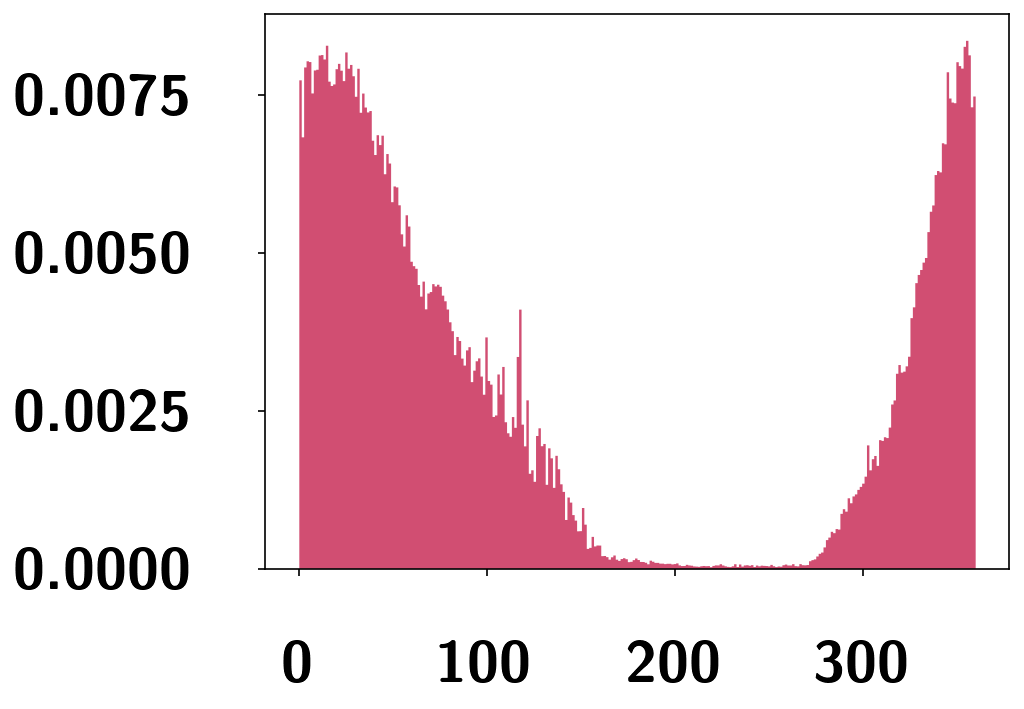

In [31]:
fig, ax = plt.subplots(dpi=dpi)

# make the hisogram
omegay, omegax, _ = hist(omega, density=True, histtype='stepfilled',
                       color=my_colors[10], bins=omega_bins, range=omega_xlim, alpha=1)

omega_bins = omegay.size
# get the middle values of bins (x is the edges, 1 more index here than for y)
omegax_mid = moving_average(omegax, 2)

omegapeak = omegay.max() # peak in the element histogram
omegamin = omegay.min()

# find the peak in sma probability
omegapeak_i = np.where(omegay == omegapeak)[0][0]
omegapeak_x_mid = omegax_mid[omegapeak_i]

# find the peak in sma probability
omegamin_i = np.where(omegay == omegamin)[0][0]
omegamin_x_mid = omegax_mid[omegamin_i]

# plt.close()
# gc.collect()

plt.show()


In [32]:
# A, mu, sigma, b, a for Gaussian + ax + b
omega_param_0 = [-2.45204396e-02,  5.31679640e+01,  2.70393346e+03,  2.61792176e-02,
       -9.95688208e-05]

# Move everything past the minimum to a negative angle
omega_wrapped2 = np.copy(omega)
omega_wrap_shift = 360 - omegamin_x_mid
omega_wrap_shift = np.round(omega_wrap_shift) # nearest integer degree
omega_wrapped2 += omega_wrap_shift

print(f'\nWrap shift: {omega_wrap_shift} deg')
omega_ann_nom_add = -omega_wrap_shift

omega_wrapped2[omega_wrapped2 > 360] -= 360
adjusted_units_orbits[3] = omega_wrapped2# update arr of orbital params

# new xlabel for adjusted parameter
if omega_wrap_shift > 0:
    omega_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\omega + {:.0f}^\circ \pmod{{360^\circ}}}}$}}'.format(omega_wrap_shift)
else:
    omega_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\omega - {:.0f}^\circ \pmod{{360^\circ}}}}$}}'.format(np.abs(omega_wrap_shift))

try:
    omega_param
except NameError:
    
    omega_param = element_hist(omega_wrapped2, 'omega', omega_var, omega_unit, omega_wrapped2_xlabel,
                               omega_annotation_str, omega_i_bounds, bins=omega_bins, xlim=(0,360),
                               plot_jump_hist=plot_omega_jump_hist,
                             fit_peak=fit_omega_peak, plot_fit=plot_omega_fit, fit_cut_fracs=cut_omega_fracs,
                             ann_x_frac=omega_ann_x_frac, param=omega_param_0, color=my_colors[8],
                             jump_cut_frac=omega_jump_cut_frac,
                            obj='hii1348b', sampler='MCMC_30M_final', alpha=0.9,
                            dpi=dpi, ann_nom_add=omega_ann_nom_add)

else:
    omega_param = element_hist(omega_wrapped2, 'omega', omega_var, omega_unit, omega_wrapped2_xlabel,
                           omega_annotation_str, omega_i_bounds, bins=omega_bins, xlim=(0,360),
                           plot_jump_hist=plot_omega_jump_hist,
                         fit_peak=fit_omega_peak, plot_fit=plot_omega_fit, fit_cut_fracs=cut_omega_fracs,
                         ann_x_frac=omega_ann_x_frac, param=omega_param, color=my_colors[8],
                         jump_cut_frac=omega_jump_cut_frac,
                        obj='hii1348b', sampler='MCMC_30M_final', alpha=0.9,
                        dpi=dpi, ann_nom_add=omega_ann_nom_add)


print(repr(omega_param))

plt.close()
gc.collect()


Wrap shift: 141.0 deg
element: [271.33898313 158.73211509 119.62173311 ... 157.20229688 211.59476555
 191.40381287]
bins: 280
None


4304

In [33]:
# deg, just for FFTKDE boundary condition (circular, in this case)
omega_min=0
omega_max=360
omega_min_mirror=False ; omega_max_mirror=False ; omega_circ_param=True
omega_fit_log=False ; omega_n_errp=2 ; omega_n_nom=2 ; omega_n_errm=2
omega_interp_pc=5.

omega_params = ['omega', omega_var, omega_unit, omega_wrapped2_xlabel, omega_annotation_str, omega_min, omega_max, omega_xlim, \
             omega_ann_x_frac, omega_min_mirror, omega_max_mirror, omega_circ_param, omega_fit_log, omega_interp_pc, \
              omega_n_nom, omega_n_errp, omega_n_errm, omega_ann_nom_add, None]

# update row in dataframe for omega with the above parameters
big_df.loc[omega_lab] = omega_params


In [34]:
omega_peak, omega_errp, omega_errm = fftkde_plot(
    omega_wrapped2,
    omega_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[omega_lab, 'peak'] = omega_peak
plt.close()
gc.collect()


Creating Plot for omega...
Total Probability in bounds of: 68.0%
omega = (153.5661 +70.6603 or -35.3061) deg

saving figure...



0

## Epoch of periastron $\mathbf{(\tau)}$

In [35]:
# variable and units for the orbital element being plotted
tau_var = 'tau'
tau_unit = ''
tau_lab = param_list[5]

# plot labels, annotations, limits, bins
tau_xlabel = r'$\boldsymbol{\tau}$'
tau_annotation_str =r'$\mathbf{{\boldsymbol{{\tau}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}}$'
tau_ann_x_frac = 0.07
tau_xlim = (0.3, 0.7) # range to plot on the x-axis (domain, I guess)
tau_bins = 280

# 68% credible interval bounds in histogram indices (printed below!)
tau_i_bounds = (106, 152)

# histogram y-jumps
plot_tau_jump_hist = False
tau_jump_cut_frac = 0.04

# Gaussian fitting
fit_tau_peak = False

if fit_tau_peak:
    plot_tau_fit = False
else:
    plot_tau_fit = False
    
cut_tau_fit_pc_l = 33
cut_tau_fit_pc_r = 10
cut_tau_fracs = (1 - cut_tau_fit_pc_l/100, 1 - cut_tau_fit_pc_r/100)


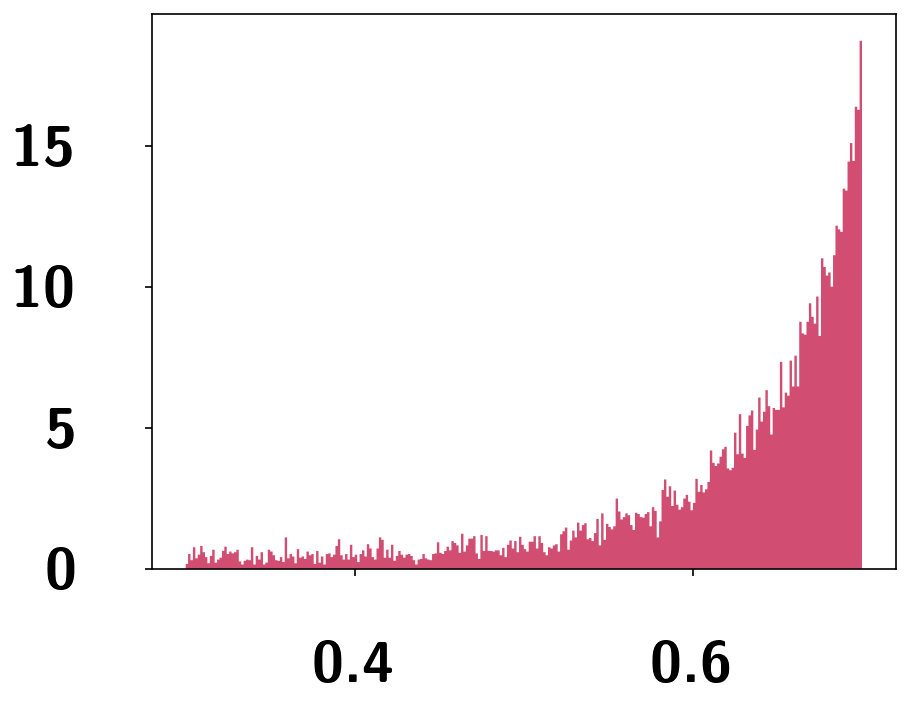

5117

In [36]:
fig, ax = plt.subplots(dpi=dpi)

# make the hisogram
tauy, taux, _ = hist(tau, density=True, histtype='stepfilled',
                       color=my_colors[10], bins=tau_bins, range=tau_xlim, alpha=1)

# get the middle values of bins (x is the edges, 1 more index here than for y)
taux_mid = moving_average(taux, 2)

taupeak = tauy.max() # peak in the element histogram
taumin = tauy.min()

# find the peak in sma probability
taupeak_i = np.where(tauy == taupeak)[0][0]
taupeak_x_mid = taux_mid[taupeak_i]

# find the peak in sma probability
taumin_i = np.where(tauy == taumin)[0][0]
taumin_x_mid = taux_mid[taumin_i]
plt.show()
gc.collect()


In [37]:
# A, mu, sigma, b, a for Gaussian + ax + b
tau_param_0 = [ 1.46994839e+03, -6.45566469e-02,  4.47573870e-01, -1.67828922e+03,
        1.30627439e+03]
# Move everything past the minimum to a negative angle
modulo = 1
tau_wrapped2 = np.copy(tau)

# shift left or right depending on peak relative to minimum
if taumin_x_mid > taupeak_x_mid:
    tau_wrap_shift = modulo - taumin_x_mid
else:
    tau_wrap_shift = 0 - taumin_x_mid
    
tau_wrapped2 += tau_wrap_shift

print(f'\nWrap shift: {tau_wrap_shift}')
tau_ann_nom_add = -tau_wrap_shift

# anything that got shifted beyond modulo or left of 0 should be wrapped accordingly.
tau_wrapped2[tau_wrapped2 > modulo] -= modulo
tau_wrapped2[tau_wrapped2 < 0] += modulo
adjusted_units_orbits[5] = tau_wrapped2# update arr of orbital params

# new xlabel for adjusted parameter
if tau_wrap_shift > 0:
    tau_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\tau}} + {:.3f} \pmod{{1}}$}}'.format(tau_wrap_shift)
else:
    tau_wrapped2_xlabel = r'\textbf{{$\boldsymbol{{\tau}} - {:.3f} \pmod{{1}}$}}'.format(np.abs(tau_wrap_shift))

try:
    tau_param
except NameError:
    
    tau_param = element_hist(tau_wrapped2, 'tau', tau_var, tau_unit, tau_wrapped2_xlabel,
                               tau_annotation_str, tau_i_bounds, bins=tau_bins, xlim=tau_xlim,
                               plot_jump_hist=plot_tau_jump_hist,
                             fit_peak=fit_tau_peak, plot_fit=plot_tau_fit, fit_cut_fracs=cut_tau_fracs,
                             ann_x_frac=tau_ann_x_frac, param=tau_param_0, color=my_colors[14],
                             jump_cut_frac=tau_jump_cut_frac,
                            obj='hii1348b', sampler='MCMC_30M_final', alpha=1,
                            dpi=dpi, ann_nom_add=tau_ann_nom_add)

else:
    tau_param = element_hist(tau_wrapped2, 'tau', tau_var, tau_unit, tau_wrapped2_xlabel,
                           tau_annotation_str, tau_i_bounds, bins=tau_bins, xlim=tau_xlim,
                           plot_jump_hist=plot_tau_jump_hist,
                         fit_peak=fit_tau_peak, plot_fit=plot_tau_fit, fit_cut_fracs=cut_tau_fracs,
                         ann_x_frac=tau_ann_x_frac, param=tau_param, color=my_colors[14],
                         jump_cut_frac=tau_jump_cut_frac,
                        obj='hii1348b', sampler='MCMC_30M_final', alpha=1,
                        dpi=dpi, ann_nom_add=tau_ann_nom_add)


print(repr(tau_param))

plt.close()
gc.collect()


Wrap shift: -0.3335714285714286
element: [0.67070752 0.51462599 0.51824733 ... 0.48583362 0.60256426 0.4925249 ]
bins: 280
None


54

In [38]:
# deg, just for FFTKDE boundary condition (circular, in this case)
tau_min=0.
tau_max=1.
tau_min_mirror=True ; tau_max_mirror=True ; tau_circ_param=False
tau_fit_log=False ; tau_n_errp=2 ; tau_n_nom=2 ; tau_n_errm=1
tau_interp_pc=5.

tau_params = ['tau', tau_var, tau_unit, tau_wrapped2_xlabel, tau_annotation_str, tau_min, tau_max, tau_xlim, \
             tau_ann_x_frac, tau_min_mirror, tau_max_mirror, tau_circ_param, tau_fit_log, tau_interp_pc, \
              tau_n_nom, tau_n_errp, tau_n_errm, tau_ann_nom_add, None]

# update row in dataframe for tau with the above parameters
big_df.loc[tau_lab] = tau_params


Make the KDE plot!

In [39]:
tau_peak, tau_errp, tau_errm = fftkde_plot(
    tau_wrapped2,
    tau_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[tau_lab, 'peak'] = tau_peak
plt.close()
gc.collect()


Creating Plot for tau...
Total Probability in bounds of: 68.0%
tau = (0.5141 +0.1048 or -0.0738) 

saving figure...



0

# Parallax $\pi$

In [40]:
# variable and units for the orbital element being plotted
plx_var = 'pi'
plx_unit = 'mas'
plx_lab = param_list[6]

# plot labels, annotations, limits, bins
plx_xlabel = r'\textbf{$\boldsymbol{\pi}$ (mas)}'
plx_annotation_str = r'$\mathbf{{ \boldsymbol{{\pi}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g}}}}}$ \textbf{{mas}}'
plx_ann_nom_add=0
plx_ann_x_frac = 0.025
plx_xlim = np.array([6.875, 7.075])# + np.array([-1*((7.1-6.85)/2), ((7.1-6.85)/2)]) # range to plot on the x-axis (domain, I guess)
plx_bins = 250

# 68% credible interval bounds in histogram indices (printed below!)
plx_i_bounds = (98, 161)

# histogram y-jumps
plot_plx_jump_hist = False
plx_jump_cut_frac = 0.08

# Gaussian fitting
fit_plx_peak = False

if fit_plx_peak:
    plot_plx_fit = False
else:
    plot_plx_fit = False
    
cut_plx_fit_pc_l = 1.1
cut_plx_fit_pc_r = 1.2
cut_plx_fracs = (1 - cut_plx_fit_pc_l/100, 1 + cut_plx_fit_pc_r/100)


In [42]:
# A, mu, sigma, b, a for Gaussian + ax + b
plx_param_0 = [1.30738883e+01,  6.97934077e+00,  1.00744775e-03,  3.54156245e+00,
       -5.39921269e-01]

# fit_x = np.linspace(*plx_xlim, 1_000)
# plt.plot(fit_x, gaussian(fit_x, *plx_param_0))

try:
    plx_param
    
except NameError:
    
    plx_param = element_hist(plx, 'i', plx_var, plx_unit, plx_xlabel, plx_annotation_str,
                             plx_i_bounds, bins=plx_bins, xlim=plx_xlim, plot_jump_hist=plot_plx_jump_hist,
                             fit_peak=fit_plx_peak, plot_fit=plot_plx_fit, fit_cut_fracs=cut_plx_fracs,
                             ann_x_frac=plx_ann_x_frac, param=plx_param_0, color=my_colors[9],
                             jump_cut_frac=plx_jump_cut_frac,
                            obj='hii1348b', sampler='MCMC_30M_final', alpha=0.8,
                            dpi=dpi)
else:

    plx_param = element_hist(plx, 'i', plx_var, plx_unit, plx_xlabel, plx_annotation_str,
                             plx_i_bounds, bins=plx_bins, xlim=plx_xlim, plot_jump_hist=plot_plx_jump_hist,
                             fit_peak=fit_plx_peak, plot_fit=plot_plx_fit, fit_cut_fracs=cut_plx_fracs,
                             ann_x_frac=plx_ann_x_frac, param=plx_param, color=my_colors[9],
                             jump_cut_frac=plx_jump_cut_frac,
                            obj='hii1348b', sampler='MCMC_30M_final', alpha=0.8,
                            dpi=dpi)
        
print(repr(plx_param))
plt.close()
gc.collect()


element: [7.02003673 6.99669472 6.97379926 ... 6.9510119  6.99295299 6.99669053]
bins: 250
None


2635

In [43]:
# deg, just for FFTKDE boundary condition
# I'm using +- 4 sigma (larger of asymmetric errors)
plx_min=6.8265
plx_max=7.1225
plx_min_mirror=False ; plx_max_mirror=False ; plx_circ_param=False
plx_fit_log=False ; plx_n_errp=2 ; plx_n_nom=4 ; plx_n_errm=2
plx_interp_pc=0.5

plx_params = ['plx', plx_var, plx_unit, plx_xlabel, plx_annotation_str, plx_min, plx_max, plx_xlim, \
             plx_ann_x_frac, plx_min_mirror, plx_max_mirror, plx_circ_param, plx_fit_log, plx_interp_pc, \
              plx_n_nom, plx_n_errp, plx_n_errm, plx_ann_nom_add, None]

# update row in dataframe for plx with the above parameters
big_df.loc[plx_lab] = plx_params


Make the KDE plot!

In [44]:
plx_peak, plx_errp, plx_errm = fftkde_plot(
    plx,
    plx_params,
    obj='hii1348b',
    sampler=sampler,
    color=my_colors[10], 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=True,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw
)

big_df.loc[plx_lab, 'peak'] = plx_peak
plt.close()
gc.collect()


Creating Plot for plx...
Total Probability in bounds of: 68.0%
pi = (6.9752 +0.0357 or -0.0256) mas

saving figure...



0

# Total Mass $M_\mathrm{tot}$

In [45]:
# variable and units for the orbital element being plotted
mtot_var = 'Mtot'
mtot_unit = 'M_Sun'
mtot_lab = param_list[7]

# plot labels, annotations, limits, bins
mtot_xlabel = r'\textbf{$\mathrm{M_\text{tot}}$ ($\mathrm{M}_\mathbf{\odot}$)}'
mtot_annotation_str = r'\textbf{{$\mathbf{{ \mathrm{{\mathbf{{M_\text{{\textbf{{tot}}}}}}}} = {:g} \substack{{+{:g} \\ \bm{{-}}{:g} }} }} \ \mathrm{{M_\odot}}$}}'
mtot_ann_nom_add = 0
mtot_ann_x_frac = 0.66
mtot_xlim = (1.05, 1.55) # range to plot on the x-axis (domain, I guess)
mtot_bins = 250

# 68% credible interval bounds in histogram indices (printed below!)
mtot_i_bounds = ( 93, 149)

# histogram y-jumps
plot_mtot_jump_hist = False
mtot_jump_cut_frac = 0.01

# Gaussian fitting
fit_mtot_peak = False

if fit_mtot_peak:
    plot_mtot_fit = False
else:
    plot_mtot_fit = False
    
cut_mtot_fit_pc_l = 20
cut_mtot_fit_pc_r = 17
cut_mtot_fracs = (1 - cut_mtot_fit_pc_l/100, 1 + cut_mtot_fit_pc_r/100)

In [46]:
# A, mu, var, b, a for Gaussian + ax + b
mtot_param_0 = [ 4.44423254,  1.28830709,  0.00781643,  0.16844715, -0.10805732]

# fit_x = np.linspace(*mtot_xlim, 1_000)
# plt.plot(fit_x, gaussian(fit_x, *mtot_param_0))

try:
    mtot_param
    
except NameError:
    
    mtot_param = element_hist(mtot, 'i', mtot_var, mtot_unit, mtot_xlabel, mtot_annotation_str,
                             mtot_i_bounds, bins=mtot_bins, xlim=mtot_xlim, plot_jump_hist=plot_mtot_jump_hist,
                             fit_peak=fit_mtot_peak, plot_fit=plot_mtot_fit, fit_cut_fracs=cut_mtot_fracs,
                             ann_x_frac=mtot_ann_x_frac, param=mtot_param_0, color=my_colors[9],
                             jump_cut_frac=mtot_jump_cut_frac,
                            obj='hii1348b', sampler='MCMC_30M_final', alpha=0.8,
                            dpi=dpi)
else:

    mtot_param = element_hist(mtot, 'i', mtot_var, mtot_unit, mtot_xlabel, mtot_annotation_str,
                             mtot_i_bounds, bins=mtot_bins, xlim=mtot_xlim, plot_jump_hist=plot_mtot_jump_hist,
                             fit_peak=fit_mtot_peak, plot_fit=plot_mtot_fit, fit_cut_fracs=cut_mtot_fracs,
                             ann_x_frac=mtot_ann_x_frac, param=mtot_param, color=my_colors[16],
                             jump_cut_frac=mtot_jump_cut_frac,
                            obj='hii1348b', sampler='MCMC_30M_final', alpha=0.8,
                            dpi=dpi)
        
print(repr(mtot_param))
plt.close()
gc.collect()

element: [1.46599336 1.19257976 1.19328583 ... 1.25611321 1.29049496 1.20230641]
bins: 250
None


2626

In [47]:
# deg, just for FFTKDE boundary condition (circular, in this case)
mtot_min=0.
mtot_max=np.inf
mtot_min_mirror=False ; mtot_max_mirror=False ; mtot_circ_param=False
mtot_fit_log=False ; mtot_n_errp=1 ; mtot_n_nom=3 ; mtot_n_errm=2
mtot_interp_pc=0.5

mtot_params = ['mtot', mtot_var, mtot_unit, mtot_xlabel, mtot_annotation_str, mtot_min, mtot_max, mtot_xlim, \
             mtot_ann_x_frac, mtot_min_mirror, mtot_max_mirror, mtot_circ_param, mtot_fit_log, mtot_interp_pc, \
              mtot_n_nom, mtot_n_errp, mtot_n_errm, mtot_ann_nom_add, None]

# update row in dataframe for mtot with the above parameters
big_df.loc[mtot_lab] = mtot_params


In [48]:
big_df.to_csv('big_df.csv')

Make the KDE plot!

In [49]:
ylab_offset = -0.13
label_margin = -11.15 * ylab_offset
mtot_ann_str = r'\textbf{$\mathbf{ \mathrm{\mathbf{M_\text{\textbf{tot}}}} = 1.30 \substack{+0.08 \\ \bm{-}0.10 } } \ \mathrm{M_\odot}$}'

mtot_peak, mtot_errp, mtot_errm = fftkde_plot(
    mtot,
    mtot_params,
    obj='hii1348b',
    sampler=sampler,
    color='k', 
    dpi=dpi,
    bw_rule='silvermans',
    jpeg=False,
    save=True,
    annotate=False,
    show_xlabel=True,
    show_ylabel=False,
    size_fac=size_fac,
    fftkde_res=fftkde_res,
    lw=lw,
    fill_alpha=0.2,
    pad_inches=0.0,
    base_size=10,
    base_margin=0.4,
    label_margin=label_margin,
    ylab_offset=ylab_offset,
    ann_title=True,
    ann_str=mtot_ann_str,
    no_ticks=True,
    no_tick_labels=True,
    plot_hist=True,
    hist_bins=400,
    hist_color='lightgray'
)

big_df.loc[mtot_lab, 'peak'] = mtot_peak
plt.close()
gc.collect()


Creating Plot for mtot...
Total Probability in bounds of: 68.0%
Mtot = (1.2995 +0.0774 or -0.1000) M_Sun

saving figure...



0

# 2D KDEs:

In [50]:
std_norm_levels = np.array([np.exp(-(n_sigma)**2/2) for n_sigma in [0.5, 1, 1.5]])[::-1]
print(std_norm_levels)
print(f'containing {[100*(1-std_norm_level) for std_norm_level in std_norm_levels]}% of the samples')

[0.32465247 0.60653066 0.8824969 ]
containing [67.53475326416503, 39.346934028736655, 11.750309741540455]% of the samples


Implementation with help from claude.ai to re-factor the identification of scatter points for speed

In [51]:
# User input
#-----------------
spine_color = 'k'
ticklab_color = 'k'
tick_color = 'k'
norm = 2 # Euclidian norm
kernel = 'gaussian'
# grid_points per axis
grid_points = 2**11# max is 2**12
N = 150 # number of contours for contourf., max 997 for saving 3/1000 for the un-filled contours?
corner_dpi = dpi # 150 seems all right, at least for the corner plot. (and > 10x10 in.)
bw_rule = 'silvermans'
plot_raw_kde = False
#-----------------


In [53]:
plt.close("all")
gc.collect()

0

In [54]:
param_list

array(['sma1', 'ecc1', 'inc1', 'aop1', 'pan1', 'tau1', 'plx', 'mtot'],
      dtype='<U4')

In [55]:
ylab_offset = -0.13
label_margin = -11.15 * ylab_offset

# run generate_corner_plots
if __name__ == '__main__':
    generate_corner_plots(
        #param_list=param_list,
        param_list=param_list[0:3],
        adjusted_units_orbits=adjusted_units_orbits,
        big_df=big_df,
        grid_points=grid_points,
        N=N,
        std_norm_levels=std_norm_levels,
        corner_dpi=corner_dpi,
        size_fac=size_fac,
        sampler=sampler,
        bw_rule=bw_rule,
        plot_raw_kde=plot_raw_kde,
        fftkde_res=fftkde_res,
        scatter_alpha=100/510,
        lw=lw,
        min_contour_lw=0.75,
        scatter_cmp_val=0.55,
        fill_alpha=0.2,
        pad_inches=0.0,
        base_size=10,
        base_margin=0.4,
        label_margin=label_margin,
        ylab_offset=ylab_offset,
        annotate=False,
        ann_title=True,
        cmap_min=0.1,
        show_peak_x_mid=True,
        show_peak_y_mid=True,
        presentation=False,
        ecc_xlabel=ecc_xlabel,
        inc_xlabel=inc_xlabel
        
    )

Making a diagonal plot for sma1
Creating Plot for sma...
fitting log
Total Probability in bounds of: 68.0%
a = (142.8634 +125.0619 or -30.7019) au

saving figure...

Making off-diagonal plot for ecc1 v. sma1
mirroring at min_x value: 1.6428522415362847
mirroring at min_y value: 0
mirroring at max_y value: 1
x_bc_count: 1
y_bc_count: 2
grid_points before adjustment: 2048
grid_points after adjustment: 8192
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.3468927687693206
np.max(x) before mask: 5.8522793388214325

np.min(y) before mask: -2.4512494216502914
np.max(y) before mask: 3.4512494216501213

fit_param_min_x: 1.6428522415362847
fit_param_max_x: inf

fit_param_min_y: 0
fit_param_max_y: 1
np.min(x) after mask and un-log (if appl.): 43.971115314109205
np.max(x) after mask and un-log (if appl.): 711671.1143342905

np.min(y) after mask and un-log (if appl.): 0.00025846077041502546
np.max(y) after mas

  0%|                                                                                                        |…

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 473144
plotting filled contours...
scattering points...
Error in off-diagonal plot (0, 1): '>' not supported between instances of 'float' and 'NoneType'
Making off-diagonal plot for inc1 v. sma1
mirroring at min_x value: 1.6428522415362847
mirroring at min_y value: 90
mirroring at max_y value: 180
x_bc_count: 1
y_bc_count: 2
grid_points before adjustment: 2048
grid_points after adjustment: 8192
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.3356857223712733
np.max(x) before mask: 5.996490678890371

np.min(y) before mask: -104.944603633068
np.max(y) before mask: 374.9446036330741

fit_param_min_x: 1.6428522415362847
fit_param_max_x: inf

fit_param_min_y: 90
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 43.9920900305046
np.max(x) after mask and un-log (if appl.): 991952.0490928673

np.min(y) after

  0%|                                                                                                        |…

n_contours: 1
np.max(outside): 1.0
np.min(outside): -1.0

Number of points outside: 427721
plotting filled contours...
scattering points...
saving figure...

Making a diagonal plot for ecc1
Creating Plot for ecc...
Total Probability in bounds of: 68.0%
e = (0.7788 +0.1187 or -0.2914) 

saving figure...

Making off-diagonal plot for inc1 v. ecc1
mirroring at min_x value: 0
mirroring at max_x value: 1
mirroring at min_y value: 90
mirroring at max_y value: 180
x_bc_count: 2
y_bc_count: 2
grid_points before adjustment: 2048
grid_points after adjustment: 8192
computing kde...
resampling grid...
finding ISJ bws...
computing kde for resample...
preparing x y z to plot...
np.min(x) before mask: -1.9619255729547032
np.max(x) before mask: 3.0253581520187423

np.min(y) before mask: -61.50799846062995
np.max(y) before mask: 336.6164052136552

fit_param_min_x: 0
fit_param_max_x: 1

fit_param_min_y: 90
fit_param_max_y: 180
np.min(x) after mask and un-log (if appl.): 0.00047406635544389175
np.max(x) 

  0%|                                                                                                        |…

n_contours: 2
np.max(outside): 0.0
np.min(outside): -2.0

Number of points outside: 316060
plotting filled contours...
scattering points...
Error in off-diagonal plot (1, 2): '>' not supported between instances of 'float' and 'NoneType'
Making a diagonal plot for inc1
Creating Plot for inc...
Total Probability in bounds of: 68.0%
i = (114.9346 +25.0358 or -9.0230) deg

saving figure...



In [56]:
plt.close("all")

In [57]:
gc.collect()

14991